In [167]:
import pandas as pd
import word2vec
import matplotlib
%matplotlib inline

# Make Dataset

In [154]:
selected_frames = pd.read_json('data/selected_frames.json')
selected_frames = selected_frames[selected_frames.law.str.len() == 1]
selected_frames.loc[selected_frames.pos_title == '', 'pos_title'] = float('nan')
selected_frames.columns = pd.MultiIndex.from_product([['raw'], selected_frames.columns])

In [155]:
selected_frames['data', 'Arg1'] = selected_frames.raw.pos_title.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Arg2'] = selected_frames.raw.pos_content.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Relation'] = selected_frames.raw.law.map(lambda x: x[0])
selected_frames.data.head()

,Arg1,Arg2,Relation
0,NaN,"(七, 年前, ，, 年, 僅, 九, 歲, 及, 八, 歲, 的, 板橋市, 某, 國小,...",殺人罪
1,"(0, ‧, 3, 坪, 喊價, 800萬, 畸零地, 圍籬, 阻, 路, 拆, ！)","(○, ．, 三, 坪, 畸零地, 能, 「, 螞蟻, 吃, 大象, 」, ？, 北市, 議...",道路交通管理處罰條例
2,"(100, cc, 催芽劑奪, 信義, 鄉四, 命)","(信義, 鄉民, 朱明福, ，, 涉嫌, 將, 催芽劑, 摻入, 米酒, ，, 導致, 前,...",殺人罪
3,"(101, 前董座, 林鴻明, 二審, 輕, 判, 1年, 8月)","(前, 台北, 101, 董事長, 林鴻明, ，, 被, 控, 掏空, 股票, 上市, 的,...",證券交易法
4,"(101, 大樓, 前添, 紛爭, 台獨, 大, 旗, 砸傷, 人)","(台北, 101, 大樓, 前, 法輪, 功, 、, 愛國, 同心, 會, 的, 爭端, ，...",傷害罪


In [156]:
selected_frames.data.Arg2.str.len().rename('Content Length').describe()

count    4022.000000
mean      364.675037
std       122.998481
min        41.000000
25%       297.000000
50%       366.000000
75%       444.000000
max       807.000000
Name: Content Length, dtype: float64

In [157]:
dataset = selected_frames.fillna('').sample(frac=1, random_state=42)
trainset = dataset[len(dataset)//4:]
validset = dataset[:len(dataset)//4]

In [158]:
relation = dataset.data.Relation.unique()
print('# Train set'.ljust(20), '%5d'%len(trainset))
print('# Valid set'.ljust(20), '%5d'%len(validset))
print('# Law in Train'.ljust(20), '%5d'%len(relation))

# Train set           3017
# Valid set           1005
# Law in Train         274


# Word2Vec

In [78]:
corpus = selected_frames.data.Arg1.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None)
corpus = selected_frames.data.Arg2.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None, mode='a')

In [52]:
f_wordvec = 'data/wordvec.txt'

In [56]:
word2vec.word2vec('data/corpus.txt', f_wordvec, binary=0)
wordvec = word2vec.load(f_wordvec)
unk = wordvec.vectors.mean(0)
with open(f_wordvec, 'r+') as f:
    f.read()
    print('<unk>', *('%.6f'%x for x in unk), file=f)
    f.seek(0)
    vocab_size = next(int(n) for n in f.readline().split())
    vocab_size += 1
    f.seek(0)
    print(vocab_size, file=f, end='')

# Train

In [161]:
import model

In [164]:
classifier = model.CNN(maxlen=450, torel=relation)

In [165]:
# opt = optim.RMSprop(lr=1.2e-3)
classifier.compile(loss='categorical_crossentropy',
                   optimizer='RMSprop',
                   metrics=['acc'])
classifier.reset()
hist = classifier.fit(trainset, validset, epochs=50, batch_size=128)

Train on 3017 samples, validate on 1005 samples
Epoch 1/50
3017/3017 [==============================] - 1s - loss: 4.4867 - acc: 0.1445 - val_loss: 4.7594 - val_acc: 0.1512
Epoch 2/50
3017/3017 [==============================] - 1s - loss: 4.1238 - acc: 0.1581 - val_loss: 4.5899 - val_acc: 0.1881
Epoch 3/50
3017/3017 [==============================] - 1s - loss: 3.8872 - acc: 0.2048 - val_loss: 4.3829 - val_acc: 0.2607
Epoch 4/50
3017/3017 [==============================] - 1s - loss: 3.5890 - acc: 0.2609 - val_loss: 4.0872 - val_acc: 0.2955
Epoch 5/50
3017/3017 [==============================] - 1s - loss: 3.3550 - acc: 0.3076 - val_loss: 3.8242 - val_acc: 0.3244
Epoch 6/50
3017/3017 [==============================] - 1s - loss: 3.1505 - acc: 0.3550 - val_loss: 3.6269 - val_acc: 0.3622
Epoch 7/50
3017/3017 [==============================] - 1s - loss: 2.9681 - acc: 0.3911 - val_loss: 3.4724 - val_acc: 0.4269
Epoch 8/50
3017/3017 [==============================] - 1s - loss: 2.7851 - a

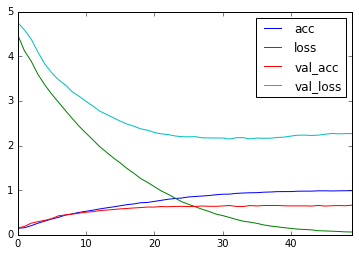

In [168]:
pd.DataFrame(hist.history).plot()